#### CONVERTING RAW CSV DATASET TO UNSTRUCTURED JSON DATA

In [79]:
import pandas as pd
from pymongo import MongoClient
import numpy as np
import matplotlib.pyplot as plt
import re

# Read CSV file into a DataFrame
df = pd.read_csv(r'C:\Users\Lekshmi Sasidharan\Desktop\DAP\PROJECT\DataSet\Air_Quality.csv')

# Convert DataFrame to JSON
json_data = df.to_json(orient='records')

# Save JSON data to a file
with open(r'C:/Users/Lekshmi Sasidharan/Desktop/DAP/PROJECT/DataSet/airquality-region.json', 'w') as json_file:
    json_file.write(json_data)
print("convereted csv raw to unstructured json")

convereted csv raw to unstructured json


#### LOADING JSON FILE TO MONGODB

In [80]:
import pandas as pd
import pymongo

# Load the DataFrame from the JSON file
df = pd.read_json(r'C:/Users/Lekshmi Sasidharan/Desktop/DAP/PROJECT/DataSet/airquality-region.json')

# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['Datas']
collection = db['Air Quality']

# Convert DataFrame to dictionary records
data = df.to_dict(orient='records')

# Clear existing data in the collection
collection.delete_many({})

# Insert data into MongoDB
for record in data:
    collection.replace_one({'_id': record['Unique ID']}, record, upsert=True)
# Count the number of documents in the original collection
original_count = collection.count_documents({})
print("Data written successfully to MongoDB")
print("Number of raw data before transformation :",original_count)

Data written successfully to MongoDB
Number of raw data before transformation : 18045


#### EXTRACTING and Transforming FROM MONGODB FOR transformation

In [81]:
import pandas as pd
from pymongo import MongoClient
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
import re

# Connect to MongoDB and extract data (Extract step)
client = MongoClient('mongodb://localhost:27017/')
db = client['Datas']
collection = db['Air Quality']
data = collection.find()

print("connected and dataset extracted from mongodb")

# Transform data (Transform step)
df = pd.DataFrame(data)
df.drop('_id', axis=1, inplace=True)  # Drop MongoDB _id field
df['Data Value'] = pd.to_numeric(df['Data Value'], errors='coerce')  # Convert 'Data Value' to numeric
df.dropna(subset=['Data Value'], inplace=True)  # Remove rows with NaN in 'Data Value'
print("Number of rows after removing null values:", len(df))



# Remove special characters and alphabets from region names
import re

# Convert 'Data Value' column to string type
df['Data Value'] = df['Data Value'].astype(str)

# Remove special characters and alphabets from region names
df['Date Value'] = df['Data Value'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', str(x)) if pd.notnull(x) else x)

# Print the number of rows after removing special characters and alphabets
print("Number of rows after removing special characters and alphabets:", len(df))



#df['Date Value'] = df['Data Value'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
#print("Number of rows after removing special characters and alphabets:", len(df))


connected and dataset extracted from mongodb
Number of rows after removing null values: 18010
Number of rows after removing special characters and alphabets: 18010


#### Identifying gases causing lung cancer

In [82]:

# Define valid gases for filtering
valid_gases = [ 
    'Nitrogen dioxide (NO2)',
    'Fine particles (PM 2.5)' ,
    'Outdoor Air Toxics - Benzene',
    'Outdoor Air Toxics - Formaldehyde' 
]

#### Connecting to Postgre

In [83]:
# Connect to PostgreSQL 
dbname = 'dap_data'
user = 'postgres'
password = 'root'
host = 'localhost'
port = '5432'

conn = psycopg2.connect(dbname=dbname, user=user, password=password, host=host, port=port)
cur = conn.cursor()

print("connected to postgre")


connected to postgre


#### Connecting to postgre and extracting valid regions(within New York City) from dataset 1

In [84]:
# Fetch distinct regions from PostgreSQL
cur.execute("SELECT DISTINCT region FROM regiondata;")
valid_regions_db = cur.fetchall()

# Convert fetched regions to a list, excluding "Other Cities"
valid_regions = [region[0] for region in valid_regions_db if region[0] != "Other Cities"]

print("Valid regions as per region dataset:")
valid_regions


Valid regions as per region dataset:


['Brooklyn Southwest',
 'New York City Centre',
 'Queens West',
 'Manhattan Central',
 'Bronx North',
 'Manhattan South',
 'Bronx South Central',
 'Brooklyn East',
 'Staten Island',
 'Queens Northeast',
 'Queens South']

#### Transformation of raw dataset

In [85]:


# Filter out invalid regions and gases based on region dataset
df = df[df['Region'].isin(valid_regions) & df['Name'].isin(valid_gases)]
print("Number of rows after filtering out invalid regions and gases:", len(df))

# Convert values in 'Data Value' column to numeric
df['Data Value'] = pd.to_numeric(df['Data Value'], errors='coerce')


# Calculate average gas values by region
avg_gas_values = df.groupby(['Region', 'Name'])['Data Value'].mean().reset_index()



Number of rows after filtering out invalid regions and gases: 12160


#### Load transformed data to Postgre

In [86]:
# Connect to PostgreSQL and load data (Load step)


#  Drop existing PostgreSQL table if it exists
cur.execute("DROP TABLE IF EXISTS air_quality;")

# Create table to store transformed data
cur.execute('''
    CREATE TABLE IF NOT EXISTS air_quality (
        region VARCHAR(50),
        name VARCHAR(100),
        avg_value FLOAT
    )
''')

# Load data into PostgreSQL - loading only relevant details from dataset
for index, row in avg_gas_values.iterrows():
    cur.execute('''
        INSERT INTO air_quality (region, name, avg_value)
        VALUES (%s, %s, %s)
    ''', (row['Region'], row['Name'], row['Data Value']))
    
    
# Commit changes and close connection
conn.commit()
conn.close()



print("Data loaded into PostgreSQL successfully.")


Data loaded into PostgreSQL successfully.


#### Plotting air quality vs region bar graph for visulaisation

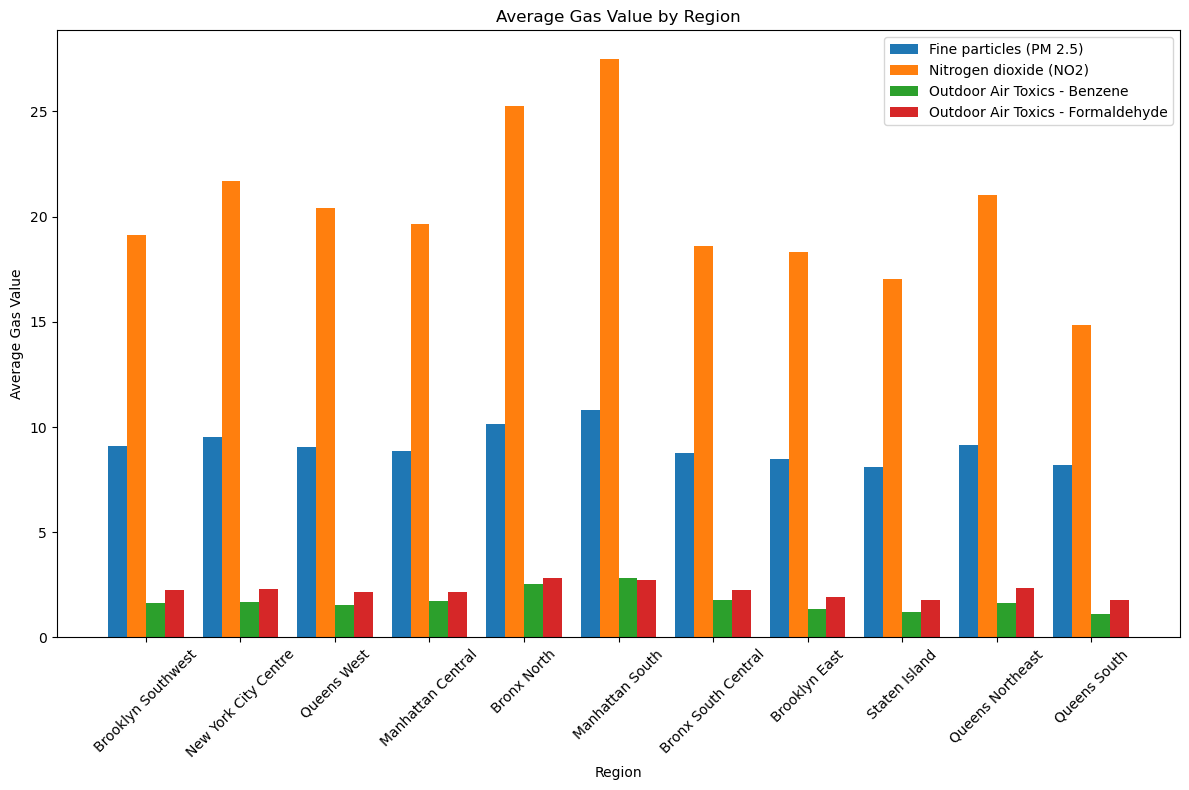

In [87]:
# Plot data as a bar graph (Load step)
plt.figure(figsize=(12, 8))

# Get unique gas names
gas_names = avg_gas_values['Name'].unique()

# Plot each gas as a separate set of bars
for i, gas in enumerate(gas_names):
    gas_data = avg_gas_values[avg_gas_values['Name'] == gas]
    plt.bar(np.arange(len(gas_data)) + i * 0.2, gas_data['Data Value'], width=0.2, label=gas)

plt.xlabel('Region')
plt.ylabel('Average Gas Value')
plt.title('Average Gas Value by Region')
plt.xticks(np.arange(len(valid_regions)) + (len(gas_names) - 1) * 0.1, valid_regions, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()